# Imports

In [1]:
import torch
import json
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm
from typing import List
from langchain_core.embeddings import Embeddings
from pydantic import BaseModel
from transformers import BridgeTowerProcessor, BridgeTowerForContrastiveLearning

In [2]:
def load_json_file(file_path):
    # Open the JSON file in read mode
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Embedding Model

https://huggingface.co/BridgeTower/bridgetower-large-itm-mlm-itc

https://huggingface.co/BridgeTower/bridgetower-large-itm-mlm-itc/discussions/4

In [3]:
class BridgeTowerEmbeddings(BaseModel, Embeddings):
    """ BridgeTower embedding model """
        
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed a list of documents using BridgeTower.

        Args:
            texts: The list of texts to embed.

        Returns:
            List of embeddings, one for each text.
        """
        array = np.zeros((100, 100, 3), dtype=np.uint8) 
        placeholder_image = Image.fromarray(array)

        processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-large-itm-mlm")
        model = BridgeTowerForContrastiveLearning.from_pretrained("BridgeTower/bridgetower-large-itm-mlm-itc")

        inputs  = processor([placeholder_image], texts, padding=True, return_tensors="pt")
        outputs = model(**inputs)

        return outputs.text_embeds.tolist()


    def embed_query(self, text: str) -> List[float]:
        """Embed a query using BridgeTower.

        Args:
            text: The text to embed.

        Returns:
            Embeddings for the text.
        """
        return self.embed_documents([text])[0]

    def embed_image_text_pairs(self, texts: List[str], images: List[str], batch_size=2) -> List[List[float]]:
        """Embed a list of image-text pairs using BridgeTower.

        Args:
            texts: The list of texts to embed.
            images: The list of path-to-images to embed
            batch_size: the batch size to process, default to 2
        Returns:
            List of embeddings, one for each image-text pairs.
        """

        # the length of texts must be equal to the length of images
        assert len(texts)==len(images), "the len of captions should be equal to the len of images"

        processor = BridgeTowerProcessor.from_pretrained("BridgeTower/bridgetower-large-itm-mlm")
        model = BridgeTowerForContrastiveLearning.from_pretrained("BridgeTower/bridgetower-large-itm-mlm-itc")

        images = [Image.open(im) for im in images]
        inputs  = processor(images, texts, padding=True, return_tensors="pt")
        outputs = model(**inputs)

        return outputs.cross_embeds.tolist()

# DB

In [4]:
from typing import Any, Iterable, List, Optional
from langchain_core.embeddings import Embeddings
import uuid
from langchain_community.vectorstores.lancedb import LanceDB

In [5]:
class MultimodalLanceDB(LanceDB):
    """`LanceDB` vector store to process multimodal data
    
    To use, you should have ``lancedb`` python package installed.
    You can install it with ``pip install lancedb``.

    Args:
        connection: LanceDB connection to use. If not provided, a new connection
                    will be created.
        embedding: Embedding to use for the vectorstore.
        vector_key: Key to use for the vector in the database. Defaults to ``vector``.
        id_key: Key to use for the id in the database. Defaults to ``id``.
        text_key: Key to use for the text in the database. Defaults to ``text``.
        image_path_key: Key to use for the path to image in the database. Defaults to ``image_path``.
        table_name: Name of the table to use. Defaults to ``vectorstore``.
        api_key: API key to use for LanceDB cloud database.
        region: Region to use for LanceDB cloud database.
        mode: Mode to use for adding data to the table. Defaults to ``overwrite``.



    Example:
        .. code-block:: python
            vectorstore = MultimodalLanceDB(uri='/lancedb', embedding_function)
            vectorstore.add_texts(['text1', 'text2'])
            result = vectorstore.similarity_search('text1')
    """
    
    def __init__(
        self,
        connection: Optional[Any] = None,
        embedding: Optional[Embeddings] = None,
        uri: Optional[str] = "/tmp/lancedb",
        vector_key: Optional[str] = "vector",
        id_key: Optional[str] = "id",
        text_key: Optional[str] = "text",
        image_path_key: Optional[str] = "image_path", 
        table_name: Optional[str] = "vectorstore",
        api_key: Optional[str] = None,
        region: Optional[str] = None,
        mode: Optional[str] = "append",
    ):
        super(MultimodalLanceDB, self).__init__(connection, embedding, uri, vector_key, id_key, text_key, table_name, api_key, region, mode)
        self._image_path_key = image_path_key
        
    def add_text_image_pairs(
        self,
        texts: Iterable[str],
        image_paths: Iterable[str],
        metadatas: Optional[List[dict]] = None,
        ids: Optional[List[str]] = None,
        **kwargs: Any,
    ) -> List[str]:
        """Turn text-image pairs into embedding and add it to the database

        Args:
            texts: Iterable of strings to combine with corresponding images to add to the vectorstore.
            images: Iterable of path-to-images as strings to combine with corresponding texts to add to the vectorstore.
            metadatas: Optional list of metadatas associated with the texts.
            ids: Optional list of ids to associate w    ith the texts.

        Returns:
            List of ids of the added text-image pairs.
        """
        # the length of texts must be equal to the length of images
        assert len(texts)==len(image_paths), "the len of transcripts should be equal to the len of images"

        # Embed texts and create documents
        docs = []
        ids = ids or [str(uuid.uuid4()) for _ in texts]
        embeddings = self._embedding.embed_image_text_pairs(texts=list(texts), images=list(image_paths))  # type: ignore
        for idx, text in enumerate(texts):
            embedding = embeddings[idx]
            metadata = metadatas[idx] if metadatas else {"id": ids[idx]}
            docs.append(
                {
                    self._vector_key: embedding,
                    self._id_key: ids[idx],
                    self._text_key: text,
                    self._image_path_key : image_paths[idx],
                    "metadata": metadata,
                }
            )

        if 'mode' in kwargs:
            mode = kwargs['mode']
        else:
            mode = self.mode
        if self._table_name in self._connection.table_names():
            tbl = self._connection.open_table(self._table_name)
            if self.api_key is None:
                tbl.add(docs, mode=mode)
            else:
                tbl.add(docs)
        else:
            self._connection.create_table(self._table_name, data=docs)
        return ids

    @classmethod
    def from_text_image_pairs(
        cls,
        texts: List[str],
        image_paths: List[str],
        embedding: Embeddings,
        metadatas: Optional[List[dict]] = None,
        connection: Any = None,
        vector_key: Optional[str] = "vector",
        id_key: Optional[str] = "id",
        text_key: Optional[str] = "text",
        image_path_key: Optional[str] = "image_path",
        table_name: Optional[str] = "vectorstore",
        **kwargs: Any,
    ):

        instance = MultimodalLanceDB(
            connection=connection,
            embedding=embedding,
            vector_key=vector_key,
            id_key=id_key,
            text_key=text_key,
            image_path_key=image_path_key,
            table_name=table_name,
        )
        instance.add_text_image_pairs(texts, image_paths, metadatas=metadatas, **kwargs)

        return instance

# Data

In [6]:
vid_metadata_path = 'sample_videos/extracted_metadata/metadatas.json'
vid_metadata = load_json_file(vid_metadata_path)

In [7]:
len(vid_metadata)

25

In [8]:
# collect transcripts and image paths
vid_trans = [vid['transcript'] for vid in vid_metadata]
vid_img_path = [vid['extracted_frame_path'] for vid in vid_metadata]

# Add Data

In [9]:
import lancedb

In [10]:
LANCEDB_HOST_FILE = "vector_db/.lancedb"
TBL_NAME = "table1"
db = lancedb.connect(LANCEDB_HOST_FILE)

In [11]:
embedder = BridgeTowerEmbeddings()

_ = MultimodalLanceDB.from_text_image_pairs(texts=vid_trans,
                                            image_paths=vid_img_path,
                                            embedding=embedder,
                                            metadatas=vid_metadata,
                                            connection=db,
                                            table_name=TBL_NAME,
                                            mode="overwrite")

Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
tbl = db.open_table(TBL_NAME)
tbl.to_pandas()

,vector,id,text,image_path,metadata
0,"[-0.024080321, -0.052563872, 0.0016731588, 0.0...",172f4b66-5cb2-4387-aa31-921eafafe46b,The image shows a person in a white tank top s...,sample_videos/extracted_frames/frame_0.jpg,{'extracted_frame_path': 'sample_videos/extrac...
1,"[-0.015138078, -0.070494376, -0.0616089, 0.010...",5ae737a7-e620-40bc-b3eb-3d0d24ceac53,The image shows a car parked in a garage. The ...,sample_videos/extracted_frames/frame_1.jpg,{'extracted_frame_path': 'sample_videos/extrac...
2,"[0.0026918044, -0.06606555, -0.05456787, 0.042...",10e71f4c-a3ba-4b3b-a54a-b43a6d80c7a5,The image shows a car parked in a garage. The ...,sample_videos/extracted_frames/frame_2.jpg,{'extracted_frame_path': 'sample_videos/extrac...
3,"[-0.009156621, -0.058463663, -0.055972535, 0.0...",1cb17dde-3c5e-4729-a36d-b6427059e00c,"The image shows a car with its door open, and ...",sample_videos/extracted_frames/frame_3.jpg,{'extracted_frame_path': 'sample_videos/extrac...
4,"[-0.012852381, -0.07919646, -0.032682035, 0.00...",89bec10c-095d-4e9f-90b7-ff6591d27281,The image shows a car in a garage with a perso...,sample_videos/extracted_frames/frame_4.jpg,{'extracted_frame_path': 'sample_videos/extrac...
5,"[-0.019033499, -0.045714322, -0.054295283, 0.0...",3a6279fb-f5ae-4b92-9e46-b17e59a127eb,The image shows a car that has been involved i...,sample_videos/extracted_frames/frame_5.jpg,{'extracted_frame_path': 'sample_videos/extrac...
6,"[-0.024100982, -0.029022915, -0.06692296, 0.03...",53c9eeb7-7db4-497c-a48b-b497c313188c,The image shows a fire in a room. The fire is ...,sample_videos/extracted_frames/frame_6.jpg,{'extracted_frame_path': 'sample_videos/extrac...
7,"[-0.008806673, -0.024967428, -0.075878516, 0.0...",3def2e5d-a4fe-46a3-94b9-a138d424d8f9,The image shows a fire in a room. The fire is ...,sample_videos/extracted_frames/frame_7.jpg,{'extracted_frame_path': 'sample_videos/extrac...
8,"[-0.017020596, -0.02154225, -0.07567439, 0.034...",d24f4978-beba-4504-9b56-b50214c08ecd,The image shows a fire in a room. The fire is ...,sample_videos/extracted_frames/frame_8.jpg,{'extracted_frame_path': 'sample_videos/extrac...
9,"[-0.012994722, -0.022922771, -0.064531945, 0.0...",ca00ac3d-36f6-4454-9d88-dd7562367dc4,The image shows a fire in a room. The fire is ...,sample_videos/extracted_frames/frame_9.jpg,{'extracted_frame_path': 'sample_videos/extrac...


In [13]:
# Creating a LanceDB vector store 
vectorstore = MultimodalLanceDB(uri=LANCEDB_HOST_FILE, embedding=embedder, table_name=TBL_NAME)
# creating a retriever for the vector store
retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={"k": 1})

In [22]:
query1 = "When does fire start ?"
results = retriever.invoke(query1)

Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# results[0].metadata

The image shows a fire in a room. The fire is bright and intense, with flames visible on the walls and ceiling. The room appears to be a utility or storage space, with a concrete floor and walls. There is a timestamp in the top left corner of the image, indicating that it was taken on December 2, 2016, at 12:02 PM.


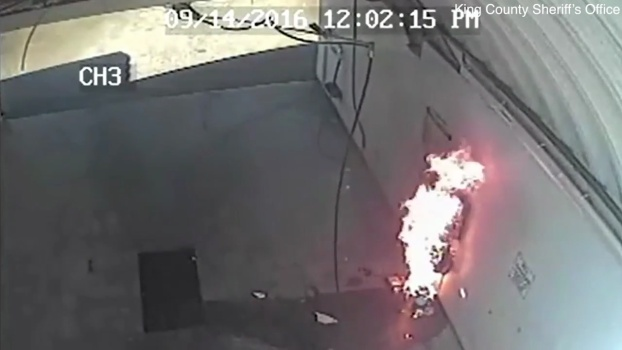

In [24]:
print(results[0].metadata['transcript'])
Image.open(results[0].metadata['extracted_frame_path'])

Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The image shows a car with its door open, and there is a person inside the car. The car is parked in a garage or a similar indoor space. The timestamp on the image indicates it was taken on September 14, 2016, at 12:01:45 PM.


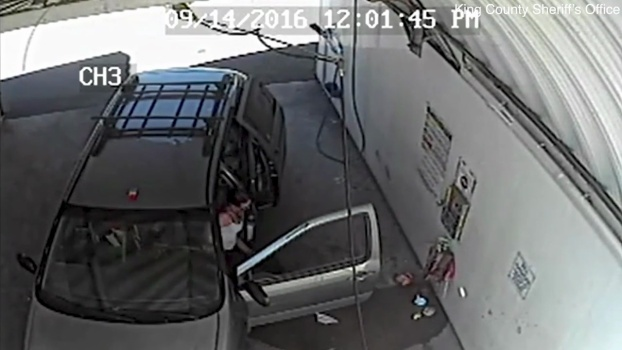

In [27]:
query1 = "Women in car"
results = retriever.invoke(query1)
print(results[0].metadata['transcript'])
Image.open(results[0].metadata['extracted_frame_path'])

Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The image shows a car with its door open, and there is a person inside the car. The car is parked in a garage or a similar indoor space. The timestamp on the image indicates it was taken on September 14, 2016, at 12:01:45 PM.


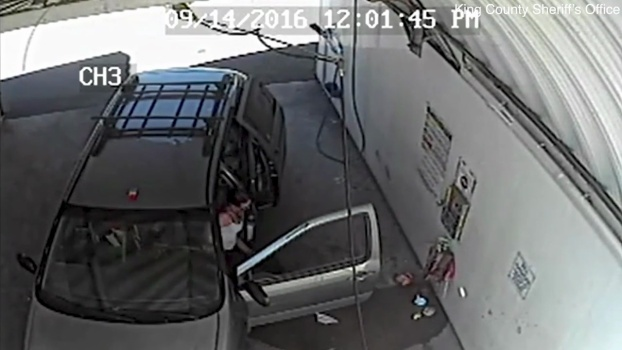

In [28]:
query1 = "drive"
results = retriever.invoke(query1)
print(results[0].metadata['transcript'])
Image.open(results[0].metadata['extracted_frame_path'])